# SVM

In [49]:
import tensorflow as tf
import datetime, os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import svm
from datetime import datetime
from scipy.stats import mode
from scipy.stats import norm

In [80]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [50]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


SVM viene de Support Vector Machines, es un algoritmo diferente a la regression logistica dado, que aunque se basa en las mismas ideas.
Agrega una seccion de confianza que no tiene la regresion logistica. Y eso muchas veces lo hace mas robusto y capaz de generalizar mejor el aprendizaje.

### SVM 

Es un algoritmo de aprendizaje supervisado creado por Vladimir Vapnik junto a otros colegas en el AT&T Bell Laboratories. Y es un algoritmo que es ampliamente popular en aplicaciones biologicas.
Es usado para clasificacion, regresion o detectar outliers. 


#### Ventajas
- Efectivo en espcaios de muchas dimensiones
- Se mantiene efectivo en casos donde el numero de dimensiones es mayor al numero de muestras.
- Usa un subset de puntos de entrenamiento en la funcion de decision que utiliza de soporte. (Support Vectors). 
- Versatil, ya que se puede customizar el kernel para la funcion de decision.


#### Desventajas
- Es posible el sobreajuste si el numero de caracteristicas es mucho mayor que el numero de muestras. Dependera de la decision de los hyperparametros para evitarlo.
- No calcula estimaciones de probabildad directamente, sino calcula un 5 Fold CV costoso.


Ejemplo de lineas de decision en regresion logistica:
<figure>
<img id="img1" src="https://miro.medium.com/max/600/0*9jEWNXTAao7phK-5.png">
</figure>

Ejemplo de una linea de decision optima (SVM):
<figure>
<img id="img1" src="https://miro.medium.com/max/600/0*0o8xIA4k3gXUDCFU.png">
</figure>

### Hipotesis 
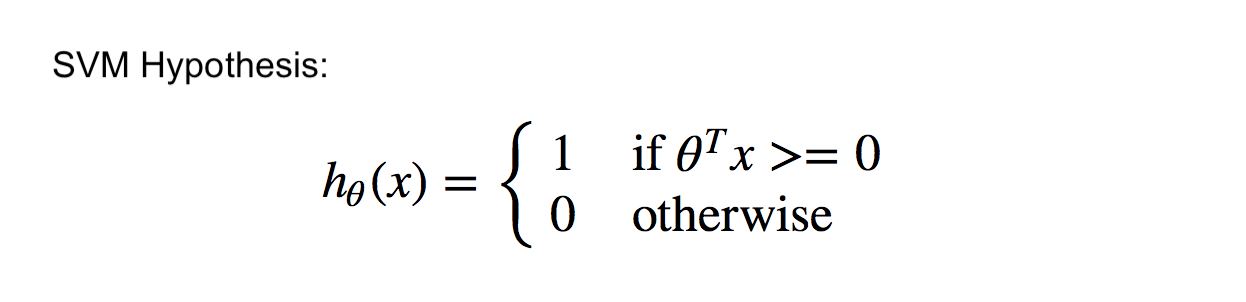

Los modelos SVM se consideran algoritmos de aprendizaje robustos dado ha estas lineas de soporte que ayudan a encontrar una barrera de decision optima. El plano de separacion entre clases que genera, le otorga la robustez que le caracteriza.

SVM  se basa en que la predicion ya no tomara valores de 0 o 1. Sino cambia estos valores por -1 y 1. Ademas la funcion de costo tambien cambia dado en parte a este cambio. Pero la hipotesis por lo tanto tomara la forma siguiente: 
$$h_{w,b}(x) = g(w^{T} x + b)$$

Notese que sigue siendo una hipotesis similar a la regresion logisitca. La diferencia ahora es que se ha aumentado el margen para separar las clases. Lo que se busca ahora es que *g(z) = 1* cuando *z* que es igual a  $w^{T} x + b)$ sea mucho mayor a 1. La frontera de decision ya no es solamente una linea. Por lo tanto *g(z) = 1* cuando *z* sea negativo. 

Nuestra funcion de costo entoces buscara generar mayor penalizacion para los casos en los que si $y = 1$ y $w^{T} x + b) < 0$ y cuando  $y = 0$ pero $w^{T} x + b) > 0$

### Funcion de costo
La funcion de costo es parecida en forma a la regresio logistica, pero ahora la funcion de SVM tiene forma de bisagra. Es por eso que le dicen hinge. 
Ahora para SVM se utilizara la siguiente: 

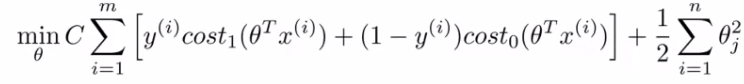

Tambien se utiliza un parametro diferente para la regularizacion. En regresion logistica normalmente se aplicaba a los parametros segun fuera el metodo (L2 o L1), y es el hyperparametro denotado por lambda. 

$$A + \lambda * B$$

En SVM se utilziara el hyperparametro `C`:
$$ C * A + B $$
Es una forma de manejar el trade off del sesgo y varianza tambien.

### Kernel Tricks
La funcion Kernel de el algoritmo de SVM es una funcion que nos permite transformar los datos de entrada (caracteristicas) moviendolo a otro espacio y encontrando hyperplanos que separen de mejor manera los datos. La idea es encontrar una funcion que permita comparar que tan similares son dos vectores. Si dos vectores son similares el producto punto entre los vectores se hara mas grande, lo que precisamente buscamos por lo tanto es una funcion que separe nuestras observaciones al tomar un valor grande. 

SVM se dice ser flexible gracias a la capacidad de encontrar mejores barreras de decision gracias a que se puede customizar por medio de la funcion kernel. 
Existen Kernels ya definidos como los que ya trae la libreria de Scikit Learn: 

- linear: $\langle x, x'\rangle.$
- polynomial: $(\gamma \langle x, x'\rangle + r)^d$
- rbf: $\exp(-\gamma \|x-x'\|^2)$
- sigmoid $\tanh(\gamma \langle x,x'\rangle + r)$

Pero la funcion de Kernel permite customizar el algoritmo SVM, y esto hace posible encontrar nuevos planos que separen de mejor manera los datos.

### Conclusiones
- A diferencia de otros algoritmos de clasificacion que tienen como salida una probabilidad, Support Vector Machine no tiene de salida una probabilidad. Si no tiene como resultado la clase directamente. 
- SVM tuvo una gran aceptacion e interes en aplicaciones medicas antes de la tendencia actual de Deep Learning, y la razon es su buen margen de confianza aun aplicado a espacios de dimensiones mayores.
- Sino se necesita una probabilidad o nivel de certeza, es una buena opcion para aplicar en cualquier tipo de deataset gracias a su flexibilidad con los kernel tricks


### Bibliografia
[Scikit Learn SVM](https://scikit-learn.org/stable/modules/svm.html)

### Ejemplo

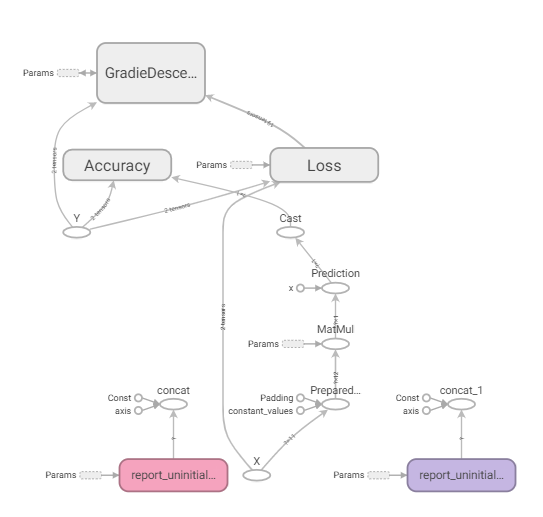

In [51]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import csv

def get_metrics(y_true, y_hat):
    performance = np.mean(np.array(precision_recall_fscore_support(y_true, y_hat)), axis=1)
    performance[-1] = accuracy_score(y_true, y_hat)
    return performance

def build_logger(file_name):
    with open(file_name, "w", encoding="utf-8", newline="\n") as f:
        csv_writer = csv.writer(f, delimiter=",", quoting=csv.QUOTE_NONE)
        csv_writer.writerow(["Model", "Config", "precision_train", "recall_train", "f-score_train", "accuracy_train", "precision_val", "recall_val", "f-score_val", "accuracy_val", "datetime"])
    def logger_csv(model_name, config_string, performance_trainning, performance_val):
        # precision, recall, fscore, acurracy
        entry = [model_name, config_string, *tuple(performance_trainning), *tuple(performance_val), datetime.today().strftime('%Y%m%d-%H%M%S')]
        with open(file_name, "a+", encoding="utf-8", newline="\n") as f:
            csv_writer = csv.writer(f, delimiter=",", quoting=csv.QUOTE_NONE)
            csv_writer.writerow(entry)          
    return logger_csv

In [82]:
def build_predict(params):
    def predict(x):
        return tf.cast(tf.math.less(0.0, tf.matmul(padding(x), params), name="Prediction"),tf.float32)
    return predict

def padding(X):
    padding = tf.constant([[0,0],[1, 0]], name="Padding")
    X_with_bias = tf.pad(X, padding, "CONSTANT", constant_values=1, name="PreparedData")
    return X_with_bias

def build_compute_loss(params, C):
    def compute_loss(x, y):
        with tf.name_scope("Loss"):
            w = tf.multiply(tf.constant(0.5), tf.reduce_sum(tf.square(params)))
            cost1 = tf.multiply(y, tf.maximum(0.0, tf.subtract(1.0, tf.matmul(padding(x), params))), name="Cost0")
            cost0 = tf.multiply(1.0 - y, tf.maximum(0.0, tf.add(1.0, tf.matmul(padding(x), params))), name="Cost1")
            hinge = tf.reduce_sum(tf.add(cost0, cost1))
            loss = tf.add(w, tf.multiply(C, hinge), name="Loss")
        return loss
    return compute_loss

def compute_accuracy(y, y_hat):
    with tf.name_scope("Accuracy"):
        accuracy = tf.equal(y_hat, y)
        accuracy = tf.cast(accuracy, tf.int32)
        accuracy = tf.divide(tf.reduce_sum(accuracy), tf.shape(y)[0])
        return accuracy 
    

def build_svm(tensor_x, tensor_y, params, lr=0.001, C=1):
    compute_loss = build_compute_loss(params, C)
    predict = build_predict(params)(tensor_x)
    loss = compute_loss(tensor_x, tensor_y)
    error_summary = tf.summary.scalar(name="ErrorSummary", tensor=loss)
    accuracy = compute_accuracy(tensor_y, predict)
    accuracy_summary = tf.summary.scalar(name="accuracySummary", tensor=accuracy)
    with tf.name_scope("GradieDescent"):
        gradient = tf.gradients(loss, [params], name="Gradient")
        update_params = tf.assign(params, params - lr * gradient[0], name="UpdateParams")
    return update_params, params, loss, error_summary, accuracy, accuracy_summary, predict

def log(theta, epoch, error, accuracy):
    print(f"MB Gradient Descent_epoch_{epoch}_error_{error}_accuracy_{accuracy}")

def fit(X, Y, batch_size=32, epochs=100, lr=0.001, C=1, print_n=10, logs_path='./logs/log_svm/graph_'):
    path = f"{logs_path}_lr_{lr}_batch_size_{batch_size}_epochs_{epochs}_C_{C}_{datetime.today().strftime('%Y%m%d-%H%M%S')}"
    tf.reset_default_graph()
    # Parameters Matrix [features + 1, 1] 
    params = tf.get_variable("Params", dtype=tf.float32, shape=[X.shape[1] + 1, 1],initializer=tf.zeros_initializer())
    # shape: (?, features)
    tensor_x = tf.placeholder(tf.float32, [None,X.shape[1]], name="X")
    # shape: (?, labels)
    tensor_y = tf.placeholder(tf.float32, [None,Y.shape[1]], name="Y")
    C_const = tf.constant(C, dtype=tf.float32, name="Lambda")
    update_params, params, loss, error_summary, accuracy, accuracy_summary, predict = build_svm(tensor_x, tensor_y, params, lr=lr, C=C_const)
    n = X.shape[0] // batch_size
    final_tetha = None
    with tf.train.MonitoredSession() as session:
        with tf.summary.FileWriter(path, session.graph) as train_writer:
            for epoch in range(epochs): 
                for i in range(n):
                    start, end = i * batch_size, (i+1) * batch_size
                    x_mbatch, y_mbatch = X[start:end,], Y[start:end,]
                    feed_dict = { tensor_x: x_mbatch, tensor_y: y_mbatch}
                    _, theta = session.run([update_params, params], feed_dict=feed_dict)
                if (epoch + 1) % print_n == 0:
                    feed_dict = { tensor_x: X, tensor_y: Y }
                    val_error, val_accuracy, e_summary,acc_summary, theta =  session.run([loss, accuracy, error_summary, accuracy_summary, params], feed_dict = feed_dict)
                    train_writer.add_summary(e_summary, epoch + 1)
                    train_writer.add_summary(acc_summary, epoch + 1)
                    log(theta, epoch + 1, val_error, val_accuracy)
            feed_dict = { tensor_x: X, tensor_y: Y }
            final_theta, y_hat, accuracy_val  = session.run([params, predict, accuracy], feed_dict=feed_dict)
    return final_theta, y_hat, accuracy_val


In [83]:
def run(x_train, y_train, x_test, y_test, batch_size=32, epochs=100, lr=0.001, C=1, print_n=10, logs_path='./logs/graph_svm_', logger=lambda *x: print(*x, sep=' ')):
    theta, y_hat_train, accuracy_train = fit(x_train, y_train, epochs=epochs, lr=lr, C=C, print_n=print_n, logs_path=logs_path)
    # shape: (?, features)
    tensor_x_test = tf.placeholder(tf.float32, [None,x_test.shape[1]], name="X_test")
    # shape: (?, labels)
    tensor_y_test = tf.placeholder(tf.float32, [None,y_test.shape[1]], name="Y_test")

    get_predictions = build_predict(theta)(tensor_x_test)
    get_accuracy = compute_accuracy(tensor_y_test, get_predictions)
    with tf.Session() as session:
        with tf.summary.FileWriter(logs_path+"prediction", session.graph) as train_writer:
            y_hat_val, accuracy_val = session.run([get_predictions, get_accuracy], feed_dict = { tensor_x_test: x_test, tensor_y_test: y_test})
    name = f"train/linear_svm_batch_size_{batch_size}_epochs_{epochs}_C_{C}"
    print(accuracy_val)
    return theta, name

In [72]:
from joblib import load
x_train = load('x_train.pkl')
y_train = load('y_train.pkl')
x_val = load('x_val.pkl')
y_val = load('y_val.pkl')

y_train.shape

(568,)

In [87]:
_, _ = run(x_train.to_numpy(), y_train.to_numpy().reshape(-1,1), x_val.to_numpy(), y_val.to_numpy().reshape(-1,1), epochs=1000, lr=0.0001, C=0.85)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
MB Gradient Descent_epoch_10_error_380.6762390136719_accuracy_0.625
MB Gradient Descent_epoch_20_error_330.3907775878906_accuracy_0.625
MB Gradient Descent_epoch_30_error_323.9678039550781_accuracy_0.625
MB Gradient Descent_epoch_40_error_319.7010192871094_accuracy_0.625
MB Gradient Descent_epoch_50_error_315.5983581542969_accuracy_0.653169014084507
MB Gradient Descent_epoch_60_error_311.70330810546875_accuracy_0.6672535211267606
MB Gradient Descent_epoch_70_error_307.9759826660156_accuracy_0.670774647887324
MB Gradient Descent_epoch_80_error_304.331787109375_accuracy_0.6919014084507042
MB Gradient Descent_epoch_90_error_300.7518005371094_accuracy_0.7147887323943662
MB Gradient Descent_epoch_100_error_297.2409973144531_accuracy_0.721830985915493
MB Gradient Descent_epoch_110_error_293.79669189453125_accuracy_0.727112676056338
MB Gradient Descent_epoch_120_error_290.41

In [81]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 13284), started 8:01:46 ago. (Use '!kill 13284' to kill it.)